In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from torch.optim import Adam

In [2]:
class RedMulticapa(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3, hidden4, hidden5, output_size):
        super(RedMulticapa, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden1)
        self.hidden2 = nn.Linear(hidden1, hidden2)
        self.hidden3 = nn.Linear(hidden2, hidden3)
        self.hidden4 = nn.Linear(hidden3, hidden4)
        self.hidden5 = nn.Linear(hidden4, hidden5)
        self.output = nn.Linear(hidden5, output_size)
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.CrossEntropyLoss()
        self.historial = []

    def feed_forward(self, X):
        x = self.hidden1(X)
        x = self.sigmoid(x)
        x = self.hidden2(x)
        x = self.sigmoid(x)
        x = self.hidden3(x)
        x = self.sigmoid(x)
        x = self.hidden4(x)
        x = self.sigmoid(x)
        x = self.hidden5(x)
        x = self.output(x)
        return x

    def back_propagate(self, X, Y):
        outputs = self.feed_forward(X)
        error = self.loss(outputs, Y)
        self.zero_grad()
        error.backward()

    def track_progress(self, error):
        self.historial.append(error.item())

    def train(self, train_X, train_Y, optimizer, ciclos=30000):
        for i in range(ciclos):
            self.back_propagate(train_X, train_Y)
            optimizer.step()
            outputs = self.feed_forward(train_X)
            error = self.loss(outputs, train_Y)
            self.track_progress(error)

    def confusion(self, test_X, test_Y):
        with torch.no_grad():
            predictions = torch.argmax(self.feed_forward(test_X), dim=1)

        num_classes = 2
        confusion_matrix_result = [[0, 0], [0, 0]]

        for i in range(len(test_Y)):
            true_label = test_Y[i]
            pred = predictions[i]

            if true_label == pred:
                if pred == 1:
                    confusion_matrix_result[0][0] += 1
                else:
                    confusion_matrix_result[1][1] += 1
            else:
                if true_label == 1:
                    confusion_matrix_result[1][0] += 1
                else:
                    confusion_matrix_result[0][1] += 1

        return confusion_matrix_result

In [ ]:
# Leer el archivo CSV
df = pd.read_csv('dfCowanDuflo.csv')
# df = pd.read_csv('df_sim.csv')

In [3]:
# 'sex' a one-hot
sex_columna = df[['sex']]
# Crear un codificador OneHotEncoder
encoder = OneHotEncoder()
# Ajustar el codificador a los datos y transformar la columna
sex_one_hot = encoder.fit_transform(sex_columna)
# Convertir la matriz de one-hot en un DataFrame
sex_one_hot_df = pd.DataFrame(sex_one_hot.toarray(), columns=encoder.get_feature_names_out(['sex']))
# Concatenar el DataFrame original con el DataFrame de one-hot
df_one_hot = pd.concat([df, sex_one_hot_df], axis=1)
# Imprimir el DataFrame resultante
df_one_hot.drop(['sex'], axis=1, inplace=True)

# 'age' a one-hot
age_columna = df[['age']]
# Crear un codificador OneHotEncoder
encoder = OneHotEncoder()
# Ajustar el codificador a los datos y transformar la columna
age_one_hot = encoder.fit_transform(age_columna)
# Convertir la matriz de one-hot en un DataFrame
age_one_hot_df = pd.DataFrame(age_one_hot.toarray(), columns=encoder.get_feature_names_out(['age']))
# Concatenar el DataFrame original con el DataFrame de one-hot
df_one_hot = pd.concat([df_one_hot, age_one_hot_df], axis=1)
# Imprimir el DataFrame resultante
df_one_hot.drop(['age'], axis=1, inplace=True)

# 'level of education' a one-hot
level_of_education_columna = df[['level of education']]
# Crear un codificador OneHotEncoder
encoder = OneHotEncoder()
# Ajustar el codificador a los datos y transformar la columna
level_of_education_one_hot = encoder.fit_transform(level_of_education_columna)
# Convertir la matriz de one-hot en un DataFrame
level_of_education_one_hot_df = pd.DataFrame(level_of_education_one_hot.toarray(), columns=encoder.get_feature_names_out(['level of education']))
# Concatenar el DataFrame original con el DataFrame de one-hot
df_one_hot = pd.concat([df_one_hot, level_of_education_one_hot_df], axis=1)
# Imprimir el DataFrame resultante
df_one_hot.drop(['level of education'], axis=1, inplace=True)
print(df_one_hot)



      ever married  HIV acquisition  HIV-testing self-efficacy  \
0                0                1                          1   
1                1                1                          1   
2                0                1                          1   
3                0                1                          1   
4                1                1                          1   
...            ...              ...                        ...   
5673             0                1                          1   
5674             0                1                          1   
5675             1                1                          1   
5676             0                1                          1   
5677             0                1                          0   

      Condom self-efficacy  Control around sexual partners  \
0                        1                               1   
1                        1                               1   
2                    

In [4]:
# Supongamos que tu DataFrame en one-hot se llama df_one_hot y la columna de la clase se llama 'clase'
X = df_one_hot.drop('HSV-2 infection', axis=1)  # Características (variables independientes)
y = df_one_hot['HSV-2 infection']  # Variable objetivo (clase)

# Dividir el conjunto de datos en entrenamiento y prueba manteniendo la proporción de clases
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]

# Imprimir las formas de los conjuntos de entrenamiento y prueba
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", Y_train.shape)
print("Forma de y_test:", Y_test.shape)

Forma de X_train: (4542, 26)
Forma de X_test: (1136, 26)
Forma de y_train: (4542,)
Forma de y_test: (1136,)


In [5]:
max_samples = max(pd.Series(Y_train).value_counts())

print(np.unique(Y_train))

for label in np.unique(Y_train):
    label_indices = np.where(Y_train == label)[0]
    while len(label_indices) < max_samples:
        label_indices = np.concatenate((label_indices, np.random.choice(label_indices, max_samples - len(label_indices))))
    np.random.shuffle(label_indices)
    if label == np.unique(Y_train)[0]:
        train_indices = label_indices
    else:
        train_indices = np.concatenate((train_indices, label_indices))

X_train = X_train.iloc[train_indices]
Y_train = Y_train.iloc[train_indices]

print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", Y_train.shape)
print("Forma de y_test:", Y_test.shape)


[0 1]
Forma de X_train: (8256, 26)
Forma de X_test: (1136, 26)
Forma de y_train: (8256,)
Forma de y_test: (1136,)


In [6]:
# Convertir los DataFrames de pandas a matrices numpy
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()

X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()

In [7]:
# Convertir las matrices numpy a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

In [14]:
input_size = 26
hidden1 = 60
hidden2 = 80  
hidden3= 90
hidden4= 80
hidden5 = 60
output_size = 2

'''
input_size = 26
hidden1 = 52
hidden2 = 60  
hidden3= 70
hidden4= 40
hidden5 = 26
output_size = 2
'''

modelo2 = RedMulticapa(input_size, hidden1, hidden2, hidden3, hidden4, hidden5, output_size)
#modelo2.load_state_dict(torch.load('pesos_red.pth'))
print(modelo2)
optimizer = Adam(modelo2.parameters(), lr=0.001)
modelo2.train(X_train, Y_train, optimizer)

RedMulticapa(
  (hidden1): Linear(in_features=26, out_features=60, bias=True)
  (hidden2): Linear(in_features=60, out_features=80, bias=True)
  (hidden3): Linear(in_features=80, out_features=90, bias=True)
  (hidden4): Linear(in_features=90, out_features=80, bias=True)
  (hidden5): Linear(in_features=80, out_features=60, bias=True)
  (output): Linear(in_features=60, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (loss): CrossEntropyLoss()
)


In [11]:
optimizer = Adam(modelo2.parameters(), lr=0.0001)
modelo2.train(X_train, Y_train, optimizer)

In [15]:
Confusion = np.copy(np.array(modelo2.confusion(X_train, Y_train)))
print("VP Entrenamiento: ", Confusion[0][0])
print("VN Entrenamiento: ", Confusion[1][1])
print("FP Entrenamiento: ", Confusion[0][1])
print("FN Entrenamiento: ", Confusion[1][0])

Confusion = np.copy(np.array(modelo2.confusion(X_test, Y_test)))
print("VP Prueba: ", Confusion[0][0])
print("VN Prueba: ", Confusion[1][1])
print("FP Prueba: ", Confusion[0][1])
print("FN Prueba: ", Confusion[1][0])

print("Matriz de confusión con Adam")

VP Entrenamiento:  2606
VN Entrenamiento:  3349
FP Entrenamiento:  779
FN Entrenamiento:  1522
VP Prueba:  35
VN Prueba:  828
FP Prueba:  204
FN Prueba:  69
Matriz de confusión con Adam


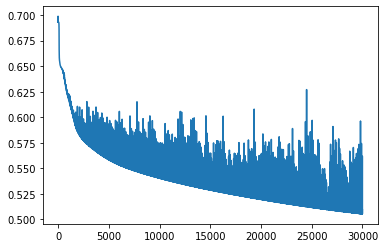

In [16]:
plt.plot(modelo2.historial)